# 1. Introduction

In this notebook, we solve the **1D Poisson equation** using a **finite-difference approach** on a uniform grid:

$$ \frac{d^2V}{dx^2} = -\frac{\rho(x)}{\varepsilon} $$

where:
- *V(x)* is the electric potential,
- *ρ(x)* is the charge density,
- *ε* is the permittivity of the medium.

We explore two types of boundary conditions:

- **Dirichlet Boundary Conditions:** The potential is fixed at both ends, i.e., $V(0) = V_{left}$ and $V(L) = V_{right}$.
- **Neumann Boundary Conditions:** The derivative of the potential (electric field) is specified at the boundaries, i.e., $ \frac{dV}{dx}(0) = \alpha $ and $\frac{dV}{dx}(L) = \alpha$.

## What This Notebook Covers:
1. Defining physical constants and setting up a uniform 1D grid.
2. Specifying boundary conditions (Dirichlet or Neumann).
3. Constructing the finite-difference matrix for the second derivative.
4. Implementing boundary conditions within the system of equations.
5. Solving the linear system and visualizing:
   - The resulting potential $V(x)$.
   - The electric field $E(x) = -\frac{dV}{dx}$.

## User Customization:
You can modify the following parameters:
- **Material properties:** Adjust permittivity *ε*.
- **Grid resolution:** Set the domain size and number of grid points *N*.
- **Charge distribution:** Define the function *ρ(x)*.
- **Boundary conditions:** Choose between Dirichlet or Neumann conditions.


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# =======================
# 2. PHYSICAL CONSTANTS
# =======================

# Elementary charge (C)
q = 1.602e-19

# Permittivity of free space, in C/(V*m)
eps0 = 8.854e-12

# Relative permittivity of silicon (example)
rel_permittivity = 11.9

# Convert to C/(V*nm) if we use nm as our length unit
eps = rel_permittivity * eps0 * 1e9

# =====================
# 2. MESH PARAMETERS
# =====================
N = 101          # number of points in the 1D domain
a = 1.0          # spacing in nm
x_domain = a * np.arange(N)  # x-coordinates from 0 to (N-1)*a in nm

# ===============================
# 2. BOUNDARY CONDITIONS (V)
# ===============================

# Choose boundary condition type: "Dirichlet" or "Neumann"
bc_type = "dirichlet"  
#Boundary conditions
left_val = 0.0
right_val = 0.0

print(f"Permittivity (C/(V*nm)): {eps}")
print(f"Number of grid points: {N}, spacing a = {a} nm.")
print(f"Domain: x in [0, {x_domain[-1]}] nm.")

Permittivity (C/(V*nm)): 0.1053626
Number of grid points: 101, spacing a = 1.0 nm.
Domain: x in [0, 100.0] nm.


# 2. Modifiable Charge Density Function

This function `get_rho` returns a charge density array $\rho(x)$ for a given set of spatial points (e.g. `x_domain`). It allows you to select from several pre-defined charge density profiles, such as:

- **"sinusoidal"**: A sine function of the form 
  $$
  \rho(x) = \text{amplitude} \cdot \sin\Bigl(2\pi k\frac{x}{L}\Bigr),
  $$
  where $L$ is the length of the domain.
- **"piecewise"**: A piecewise constant distribution (e.g., positive in one region, zero in another, and negative in another).
- **"gaussian"**: A Gaussian profile given by 
  $$
  \rho(x) = \text{amplitude} \cdot \exp\Bigl(-\frac{(x-\text{center})^2}{2\,\text{width}^2}\Bigr).
  $$

You can modify the parameters (`amplitude`, `center`, `width`, `k`) via keyword arguments to shape the distribution as desired.

### Exercise:  
Try adding your own custom charge density function (for example, a square wave or a linear ramp) by editing the default function. Observe how your modifications affect the computed potential and electric field.

In [4]:
def get_rho(x, choice="sinusoidal", **kwargs):
    """
    Returns a charge density array rho(x) for the given x-domain.
    
    Parameters
    ----------
    x : np.ndarray
        The array of spatial points (e.g. x_domain).
    choice : str
        Determines which kind of charge distribution to use.
        Options might include:
          "sinusoidal" : A sin(2*pi*k*x/L) type
          "piecewise"   : e.g. positive in one region, zero in another, negative in another
          "gaussian"    : A Gaussian distribution
          ... or custom ...
    **kwargs
        Additional parameters for shaping the distribution (amplitude, center, width, etc.).
    
    Returns
    -------
    rho : np.ndarray
        Charge density array (C/nm if we are being consistent with our units).
    """
    
    # Example parameters
    amplitude = kwargs.get("amplitude", 1e-6)   # default amplitude
    center    = kwargs.get("center", x[len(x)//2])  # default center is middle
    width     = kwargs.get("width", 10.0)           # for e.g. Gaussian
    k         = kwargs.get("k", 1.0)                # wave number for sinusoid
    
    L = x[-1] - x[0]  # approximate domain length
    
    if choice == "sinusoidal":
        # sinusoidal distribution: amplitude * sin(k * 2π * x / L)
        rho = amplitude * np.sin(k * 2*np.pi * x / L)
        
    elif choice == "piecewise":
        # piecewise example: positive in [0, L/3], 0 in [L/3, 2L/3], negative in [2L/3, L]
        # amplitude sets the magnitude
        rho = np.zeros_like(x)
        region1 = (x >= 0)       & (x < L/3)
        region2 = (x >= L/3)     & (x < 2*L/3)
        region3 = (x >= 2*L/3)   & (x <= L)
        rho[region1] = +amplitude
        rho[region2] = 0.0
        rho[region3] = -amplitude
        
    elif choice == "gaussian":
        # a Gaussian distribution: amplitude * exp(-(x - center)^2 / (2 * width^2))
        rho = amplitude * np.exp(-0.5 * ((x - center)/width)**2)
        
    else:
        # user-defined or fallback
        # By default, return zeros if no recognized choicex
        rho = np.zeros_like(x)
        
    return rho


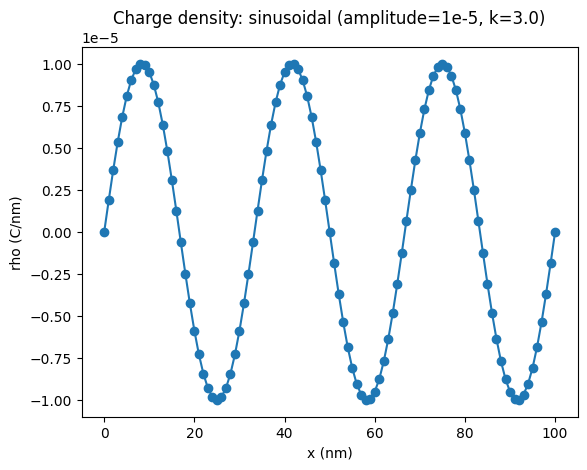

In [5]:
# Let's illustrate the different "choice" options for get_rho

# 1) Sinusoidal distribution
rho_sin = get_rho(x_domain, choice="sinusoidal", amplitude=1e-5, k=3.0)
plt.figure()
plt.plot(x_domain, rho_sin, 'o-')
plt.title("Charge density: sinusoidal (amplitude=1e-5, k=3.0)")
plt.xlabel('x (nm)')
plt.ylabel('rho (C/nm)')
plt.show()


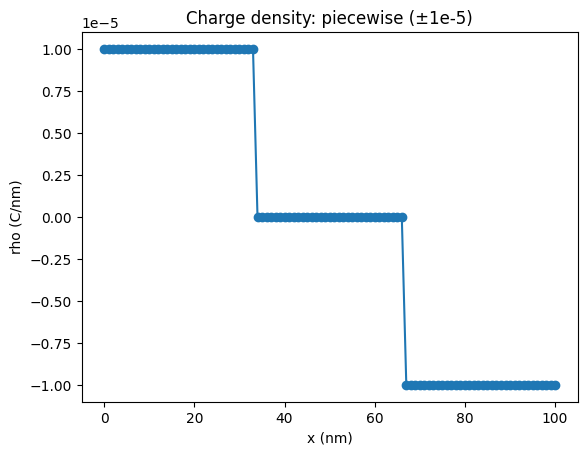

In [6]:

# 2) Piecewise distribution
rho_piecewise = get_rho(x_domain, choice="piecewise", amplitude=1e-5)
plt.figure()
plt.plot(x_domain, rho_piecewise, 'o-')
plt.title("Charge density: piecewise (±1e-5)")
plt.xlabel('x (nm)')
plt.ylabel('rho (C/nm)')
plt.show()



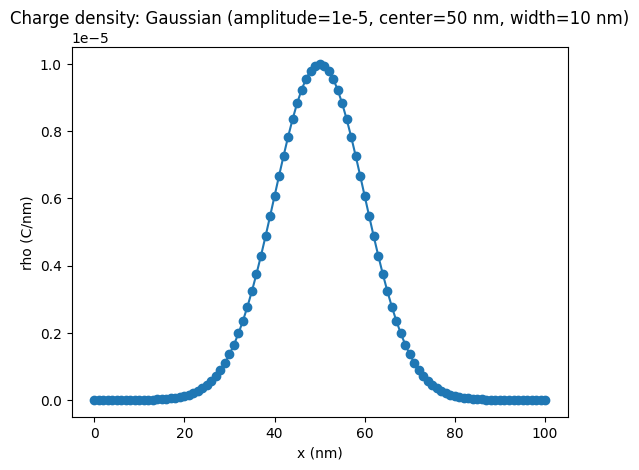

In [7]:
# 3) Gaussian distribution
rho_gauss = get_rho(x_domain, choice="gaussian", amplitude=1e-5, center=50.0, width=10.0)
plt.figure()
plt.plot(x_domain, rho_gauss, 'o-')
plt.title("Charge density: Gaussian (amplitude=1e-5, center=50 nm, width=10 nm)")
plt.xlabel('x (nm)')
plt.ylabel('rho (C/nm)')
plt.show()

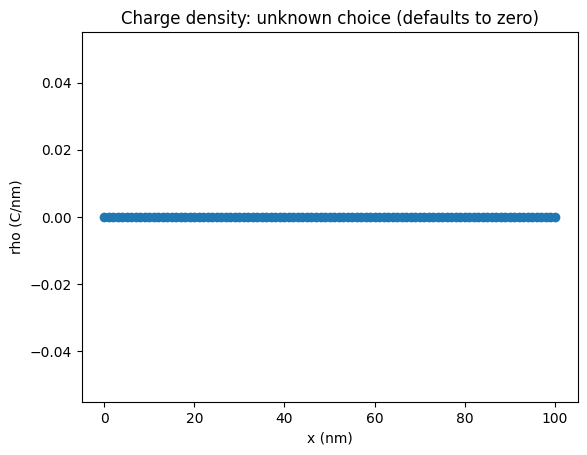

In [8]:
# 4) Fallback / unrecognized choice (defaults to zeros)
rho_unknown = get_rho(x_domain, choice="my_custom_function")
plt.figure()
plt.plot(x_domain, rho_unknown, 'o-')
plt.title("Charge density: unknown choice (defaults to zero)")
plt.xlabel('x (nm)')
plt.ylabel('rho (C/nm)')
plt.show()

# 3. Building the Finite-Difference Matrix and Applying Boundary Conditions

We now build the tridiagonal matrix **A** that approximates 
$$
\frac{\partial^2 V}{\partial x^2}
$$
using a finite-difference method. Recall that on a uniform grid with spacing $a$, the second derivative at an interior node $i$ is approximated by:
$$
\frac{V_{i+1} - 2V_i + V_{i-1}}{a^2}.
$$

In our code, we construct **A** with:
- **Main Diagonal:** $-2$ (corresponding to $-2V_i$).
- **Sub- and Super-Diagonals:** $+1$ (corresponding to $V_{i-1}$ and $V_{i+1}$).

The entire matrix is then multiplied by $1/a^2$ for the correct physical scaling.

After building the core matrix, we modify the first and last rows to apply boundary conditions. Two types of boundary conditions are demonstrated:

- **Dirichlet Boundary Conditions:**  
  Here, the potential is fixed at the boundaries, i.e., 
  $$
  V(0)=V_{\text{left}} \quad \text{and} \quad V(N-1)=V_{\text{right}}.
  $$
  This is done by overwriting the first and last rows of the matrix **A** and setting the corresponding entries of the right-hand side vector **b**.

- **Neumann Boundary Conditions:**  
  In this case, the derivative of the potential (or the electric field) is specified at the boundaries. For example:
  $$
  \frac{V(1)-V(0)}{a} = \text{left\_val} \quad \text{and} \quad \frac{V(N-1)-V(N-2)}{a} = \text{right\_val}.
  $$
  We enforce these conditions by modifying the first and last rows of **A** (and the corresponding **b** entries) to incorporate the finite-difference approximation of the derivative.



In [9]:
def build_matrix_A(N, a):
    """
    Builds the N x N matrix for the second-derivative operator with uniform spacing 'a'.
    This is the standard tridiagonal approach:
         -2 on the main diagonal
         +1 on the sub- and super-diagonals
    multiplied by (1/a^2).

    Returns
    -------
    A : np.ndarray (shape=(N,N))
        The core finite-difference matrix for d^2/dx^2 (no BC applied).
    """
    A = np.zeros((N, N))
    
    # Fill interior with -2 on the diagonal, +1 on off-diagonals
    for i in range(N):
        A[i, i] = -2.0
        if i + 1 < N:
            A[i, i + 1] = 1.0
        if i - 1 >= 0:
            A[i, i - 1] = 1.0
    
    # Incorporate factor of 1/a^2 for physical consistency
    A *= 1.0 / a**2
    
    return A


def apply_boundary_conditions(A, b, bc_type,
                              left_val=0.0, right_val=0.0,
                              a=1.0):
    """
    Modifies the matrix A and vector b to enforce either Dirichlet or Neumann BCs.
    
    Parameters
    ----------
    A : (N, N) ndarray
        The second-difference matrix (unmodified).
    b : (N,) ndarray
        The right-hand side vector (e.g., from -rho/eps).
    bc_type : str
        Either "dirichlet" or "neumann".
    left_val, right_val : float
        * If bc_type == "dirichlet":
            left_val = V(0),   right_val = V(N-1).
        * If bc_type == "neumann":
            left_val = dV/dx(0),   right_val = dV/dx(L).
    a : float
        The mesh spacing, needed for the Neumann boundary condition equations.
    
    Notes
    -----
    Dirichlet case overwrites row 0 and row N-1 to fix V(0) and V(N-1).
    Neumann case overwrites row 0 and row N-1 to fix the discrete derivative:
       (V1 - V0)/a = left_val
       (V(N-1) - V(N-2))/a = right_val
    """
    N = A.shape[0]
    if bc_type.lower() == "dirichlet":
        # ------------------
        # Left boundary: V(0) = left_val
        # ------------------
        A[0, :] = 0.0
        A[0, 0] = 1.0
        b[0]    = left_val
        
        # ------------------
        # Right boundary: V(N-1) = right_val
        # ------------------
        A[N-1, :] = 0.0
        A[N-1, N-1] = 1.0
        b[N-1]      = right_val
    
    elif bc_type.lower() == "neumann":
        # ------------------
        # Left boundary:  dV/dx(0) = left_val
        # Discrete approx: (V1 - V0)/a = left_val
        # => V0 - V1 = - left_val*a
        # We'll choose row 0 as: V0 - V1 = (left_val)*a (the sign is a matter of choice).
        # The typical form is:
        #    A[0, 0] = +1,  A[0,1] = -1,  b[0] = left_val * a
        # which ensures (V1 - V0)/a = left_val
        A[0, :] = 0.0
        A[0, 0] =  1.0
        A[0, 1] = -1.0
        b[0]    = left_val * a
        
        # ------------------
        # Right boundary:  dV/dx(L) = right_val
        # Discrete approx: (V(N-1) - V(N-2))/a = right_val
        # =>  -V(N-2) + V(N-1) = right_val * a
        A[N-1, :] = 0.0
        A[N-1, N-1] =  1.0
        A[N-1, N-2] = -1.0
        b[N-1]      = right_val * a
    
    else:
        raise ValueError("bc_type must be either 'dirichlet' or 'neumann'.")
    


# Build the matrix
A = build_matrix_A(N, a)

### 5. Constructing the RHS and Solving the Linear System

Our resulting linear system can be written as

$$
\mathbf{A} \cdot \mathbf{V} = - \frac{1}{\varepsilon} \rho,
$$

where **A** is the finite-difference matrix (including the factor $1/a^2$) and the right-hand side vector **b** is defined by

$$
b_i = -\frac{\rho_i}{\varepsilon}.
$$

In this section, we:
1. Prompt the user for the desired charge density profile.
2. Build the RHS vector **b** using the relation above.
3. Apply the chosen boundary conditions (Dirichlet or Neumann).
4. Solve the linear system to obtain the potential **V**.
5. Compute the electric field $E = -dV/dx$ and plot both the potential and the electric field.

Choose your charge density form [sin, piecewise, gauss, unknown]:  gauss


rho_choice set to 'gauss'


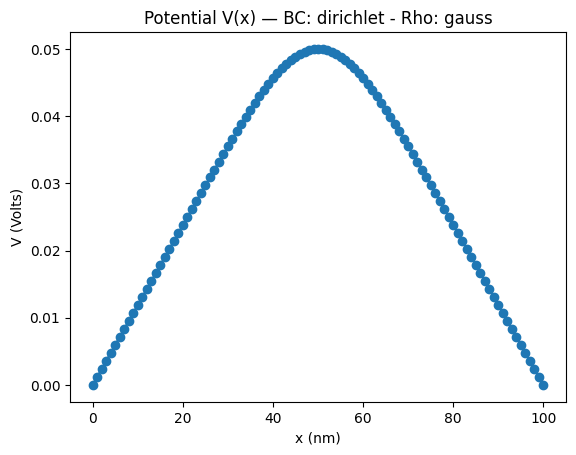

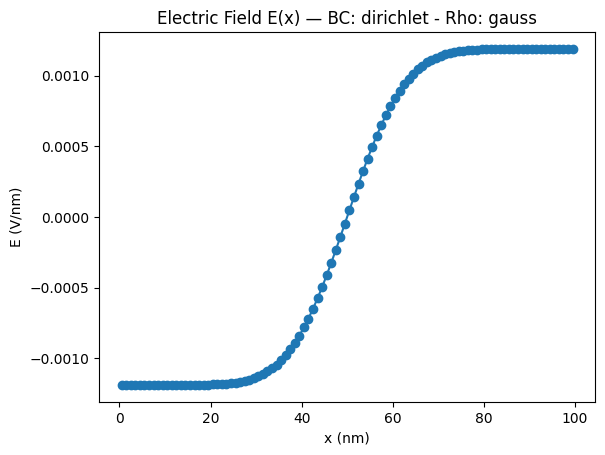

In [17]:
# 5. CONSTRUCT RHS AND SOLVE

# 1) Prompt user for the desired charge density profile
rho_choice = input("Choose your charge density form [sin, piecewise, gauss, unknown]: ")

if rho_choice == "sin":
    rho_array = rho_sin
    print("rho_choice set to 'sin'")
elif rho_choice == "piecewise":
    rho_array = rho_piecewise
    print("rho_choice set to 'piecewise'")
elif rho_choice == "gauss":
    rho_array = rho_gauss
    print("rho_choice set to 'gauss'")
else:
    rho_array = rho_unknown
    print(f"rho_choice '{rho_choice}' is unknown; defaulting to rho_unknown")

# 3) Build the right-hand side:  b = - rho / eps
b = -(rho_array / eps)

# 4) Copy A so we don't overwrite the original
A_system = A.copy()
b_system = b.copy()

# 5) Apply the chosen boundary condition
apply_boundary_conditions(A_system, b_system, bc_type,
                              left_val=left_val, right_val=right_val,
                              a=a)

# 6) Solve the system
V_solution = np.linalg.solve(A_system, b_system)

# 7) Plot the resulting potential
plt.figure()
plt.plot(x_domain, V_solution, 'o-')
plt.title(f"Potential V(x) — BC: {bc_type} - Rho: {rho_choice}")
plt.xlabel('x (nm)')
plt.ylabel('V (Volts)')
plt.show()

# 8) Compute and plot electric field: E = - dV/dx
E = -np.diff(V_solution) / a
x_E = 0.5 * (x_domain[:-1] + x_domain[1:])  # midpoint definition

plt.figure()
plt.plot(x_E, E, 'o-')
plt.title(f"Electric Field E(x) — BC: {bc_type} - Rho: {rho_choice}")
plt.xlabel('x (nm)')
plt.ylabel('E (V/nm)')
plt.show()